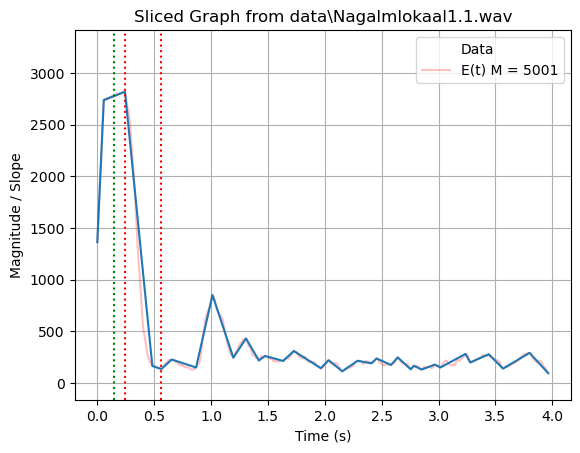

0.7255079643470407
[0.7255079643470407]


In [2]:
import os
import numpy as np
from math import log10
import matplotlib.pyplot as plt
from scipy.io.wavfile import read
from scipy.signal import find_peaks
import scipy.signal
import scipy.io.wavfile

def Hilbert_transform(signal):
    analytic_signal = scipy.signal.hilbert(signal)
    return np.abs(analytic_signal)

def moving_average_filter(signal, M):
    kernel = np.ones(M) / M
    return np.convolve(signal, kernel, mode='same')

def process_wav_file(file_path):
    sample_rate, data = read(file_path)
    length = len(data) / sample_rate
    time = np.linspace(0, length, len(data))
    datarms = np.abs(data)
    
    num_sections = 200
    section_length = len(datarms) // num_sections
    
    x_fit = []
    y_fit = []
    
    for i in range(num_sections):
        start_idx = i * section_length
        end_idx = (i + 1) * section_length if i < num_sections - 1 else len(datarms)
        section_db = datarms[start_idx:end_idx]
        section_time = time[start_idx:end_idx]
    
        peaks, _ = find_peaks(section_db, prominence=None)
    
        if len(peaks) > 0:
            max_peak_idx = peaks[np.argmax(section_db[peaks])]
            x_fit.append(section_time[max_peak_idx])
            y_fit.append(section_db[max_peak_idx])
            
    average_meanline = np.mean(y_fit) * 1.5
    peaks_fit, _ = find_peaks(y_fit, height=average_meanline)
    peaks_fit_point = peaks_fit[-1] * (length / num_sections)
    
    return peaks_fit_point, time, data, sample_rate

def douglas_peucker(points, epsilon):
    start, end = points[0], points[-1]
    dmax = np.max(np.abs(np.cross(end - start, start - points[1:-1])) / np.linalg.norm(end - start))
    if dmax > epsilon:
        index = np.argmax(np.abs(np.cross(end - start, start - points[1:-1])) / np.linalg.norm(end - start))
        results1 = douglas_peucker(points[:index + 2], epsilon)
        results2 = douglas_peucker(points[index + 1:], epsilon)
        return np.vstack((results1[:-1], results2))
    else:
        return np.array([start, end])

def find_start_end(signal, filter_index):
    
    data = np.diff(signal[filter_index:, 1])
    time = np.diff(signal[filter_index:, 0])
    start = None
    end = None

    for i in range(len(data)):
        if data[i] < 0 and (start is None or start > i):
            start = i
        elif start is not None and data[i] >= 0:
            if data[i-1] > -18*(20*time[i-1]):
                end = i-1
            else:
                end = i
            break

    return start, end

def remove_values_below_threshold(data, threshold):
    return [value for value in data if value >= threshold]

def process_sliced_graph(peaks_fit_point, time, data, sample_rate):
    
    datarms_sliced = data[int((peaks_fit_point-0.25)*sample_rate):]
    time_sliced = time[int((peaks_fit_point-0.25)*sample_rate):]-peaks_fit_point+0.25

    amplitude_envelope = Hilbert_transform(datarms_sliced)
    smoothed_signal = moving_average_filter(amplitude_envelope, 5001)
    
    epsilon = 0.1
    simplified_curve = douglas_peucker(np.column_stack(((np.arange(len(smoothed_signal)) / sample_rate), smoothed_signal)), epsilon)
    
    threshold = 0.15
    filtered_data = remove_values_below_threshold(simplified_curve[:, 0], threshold)
    filter_index = len(simplified_curve)-len(filtered_data)
    
    start, end = find_start_end(simplified_curve, filter_index)

    startTime = simplified_curve[filter_index:, 0][start]
    endTime = simplified_curve[filter_index:, 0][end]
    startValue = simplified_curve[filter_index:, 1][start]
    endValue = simplified_curve[filter_index:, 1][end]
    
    dBstart = 20*log10(startValue)
    dBend = 20*log10(endValue)
    
    dBdrop = dBstart - dBend
    NtTime = endTime - startTime
    if dBdrop != 0:
        Nt60 = NtTime * (60/dBdrop)
    else: Nt60 = 0
    
    plt.figure()
    plt.plot(time_sliced, abs(datarms_sliced), 'g-', label='Data', alpha=0.)
    plt.plot(np.arange(len(smoothed_signal)) / sample_rate, smoothed_signal, color = 'r', label='E(t) M = 5001', alpha = 0.25 )
    plt.plot(simplified_curve[:, 0], simplified_curve[:, 1])
    plt.axvline(x=startTime, color = 'r', linestyle = 'dotted')
    plt.axvline(x=endTime, color = 'r', linestyle = 'dotted')
    plt.axvline(x=0.15, color = 'g', linestyle = 'dotted')
    plt.xlabel('Time (s)')
    plt.ylabel('Magnitude / Slope')
    plt.title(f'Sliced Graph from {file_path}')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print(Nt60)
    Naglam_result_array.append(Nt60)

directory_name = "data"
Naglam_result_array = []

for file_name in os.listdir(directory_name):
    file_path = os.path.join(directory_name, file_name)
    if os.path.isfile(file_path):
        peaks_fit_point, time, data, sample_rate = process_wav_file(file_path)
        process_sliced_graph(peaks_fit_point, time, data, sample_rate)
print(Naglam_result_array)

[[0.7255079643470407, 0.9320297163166538, 0.7300197554205207, 0.8418820737497541, 0.7317063954266313, 0.7912606751630675, 0.8980492380695534, 0.8421225973901809, 0.6956715618791165], [0.9070738683853327, 0.943438143457208, 0.6084167355546612, 0.7122805637279147, 0.6200766140587627, 0.49554986356605046, 0.9482872943878922, 0.8609255137938023, 0.6696715903630154], [0.6179228061431897, 0.6090494333349968, 0.768535422567997, 0.5743240382532686, 0.5238994584522303, 0.572390783954023, 0.6033151618782008, 0.8926734928577473, 0.7255079643470407], [0.6488471229144614, 0.8125087908478703, 0.6867367442511714, 0.5000473024493286, 0.5589870055889549, 0.5800380140605431, 0.6337830535053578, 0.5903520509704385, 1.0354508697287053], [2.5, 2.5, 0.8047249142561009, 0.7682848514008751, 0.6630427512333553, 0.6245972145950298, 0.6380864526208939, 0.7841149024508597, 0.9347131015835537], [2.5, 2.5, 0.7243506427940515, 0.9594362889252678, 0.7657334935947261, 0.853740891679275, 0.5975476091616243, 0.693901378

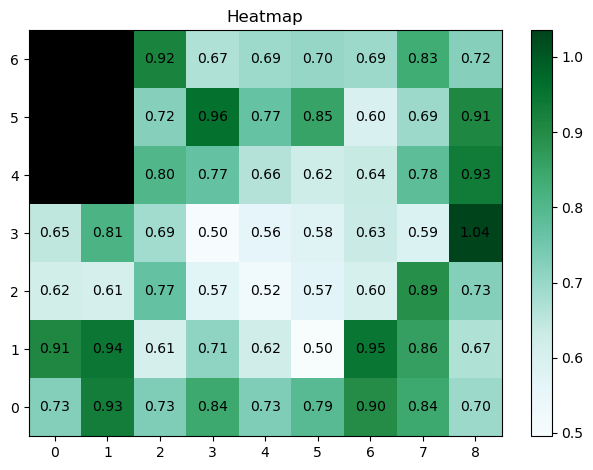

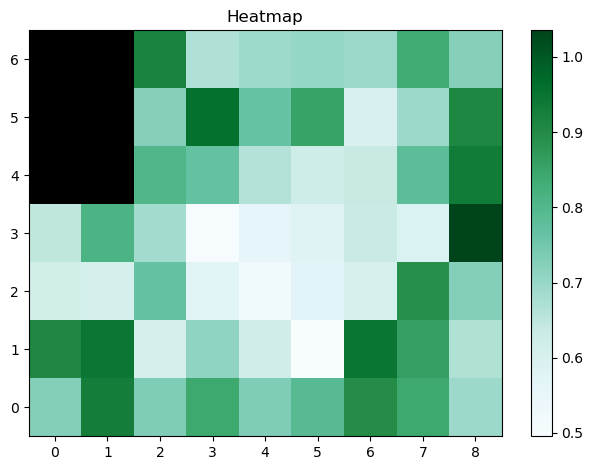

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def split_list(alist, parts=1):
    length = len(alist)
    return [ alist[i*length // parts: (i+1)*length // parts] 
             for i in range(parts) ]

Naglam_result_array = [0.7255079643470407, 0.9070738683853327, 0.943438143457208, 0.6084167355546612, 0.7122805637279147, 0.6200766140587627, 0.49554986356605046, 0.9482872943878922, 0.8609255137938023, 0.7255079643470407, 0.7255079643470407, 0.9320297163166538, 0.6090494333349968, 0.768535422567997, 0.5743240382532686, 0.8948661867965592, 0.6749740841427537, 0.6033151618782008, 1.0061210243705996, 0.7255079643470407, 0.6488471229144614, 0.8125087908478703, 0.6218005456840519, 0.6867367442511714, 0.5000473024493286, 0.6613622073078856, 0.6893603023761029, 0.6337830535053578, 0.5903520509704385, 0, 0.8047249142561009, 0.8418820737497541, 0.7682848514008751, 0.6630427512333553, 0, 0.6380864526208939, 0.7841149024508597, 1.2399448055473223, 0.7243506427940515, 0.9594362889252678, 0.7317063954266313, 0.7657334935947261, 0.853740891679275, 0.5261958558053206, 0.9914355149184146, 0.9096641008970868, 0.9164999723681803, 0.6669804268496877, 0.5170799983242357, 7.565256626333268, 7.3588307987559185, 0.2799019206057865, 1.113886694269775, 0.8421225973901809, 0.6956715618791165, 0, 0, 2.5,2.5,2.5,2.5,2.5,2.5]
Newlist = Naglam_result_array[:]

#handmatige data
Newlist[9] = 0.6696715903630154
Newlist[22] = 0.7300197554205207
Newlist[15] = 0.5238994584522303
Newlist[16] = 0.572390783954023
Newlist[49] = 0.7912606751630675
Newlist[52] = 0.8980492380695534
Newlist[25] = 0.5589870055889549
Newlist[26] = 0.5800380140605431
Newlist[34] = 0.6245972145950298
Newlist[29] = 1.0354508697287053
Newlist[37] = 0.9347131015835537
Newlist[43] = 0.5975476091616243
Newlist[44] = 0.693901378727667
Newlist[48] = 0.69232494775498233
Newlist[50] = 0.7034323298261108
Newlist[51] = 0.6944864484949844
Newlist[55] = 0.83461254767872524
Newlist[56] = 0.7234410234703879
Newlist[10] = 0.6179228061431897
Newlist[18] = 0.8926734928577473
    
order = [0,11,22,31,40,49,52,53,54,1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,17,18,19,20,21,23,24,25,26,27,28,29,62,61,30,32,33,34,35,36,37,60,59,38,39,41,42,43,44,45,58,57,46,47,48,50,51,55,56]
mylist = [Newlist[i] for i in order]

data = split_list(mylist, parts=int(len(mylist)**.5))
print(data)
specific_values = [2.5] 
for value in specific_values:
    data = [[np.nan if element == value else element for element in row] for row in data]


x = np.arange(len(data[0]))
y = np.arange(len(data))

data_min, data_max = np.nanmin(data), np.nanmax(data)

fig, ax = plt.subplots()

c = ax.pcolormesh(x, y, data, cmap='BuGn', vmin=data_min, vmax=data_max)
ax.set_title('Heatmap')

for i in range(len(data)):
    for j in range(len(data[0])):
        if not np.isnan(data[i][j]):
            if data[i][j] is not None and data[i][j] != 0.49:
                plt.text(j , i , f'{data[i][j]:.2f}', ha='center', va='center', color='black')
            else:
                plt.text(j , i , 'Nan', ha='center', va='center', color='black')
            
fig.colorbar(c, ax=ax)

c.set_facecolor('k')
c.cmap.set_bad(color='k')

fig.tight_layout()
plt.show()

fig, ax = plt.subplots()

c = ax.pcolormesh(x, y, data, cmap='BuGn', vmin=data_min, vmax=data_max)
ax.set_title('Heatmap')

for i in range(len(data)):
    for j in range(len(data[0])):
        if not np.isnan(data[i][j]):
            if data[i][j] is not None and data[i][j] != 0.49:
                plt.text(j , i , f'{data[i][j]:.2f}', ha='center', va='center', color='black', alpha = 0)
            else:
                plt.text(j , i , 'Nan', ha='center', va='center', color='black')
                
c.cmap.set_bad(color='k')
            
fig.colorbar(c, ax=ax)

fig.tight_layout()
plt.show()
